In [2]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy
from IPython.display import Image

# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [3]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

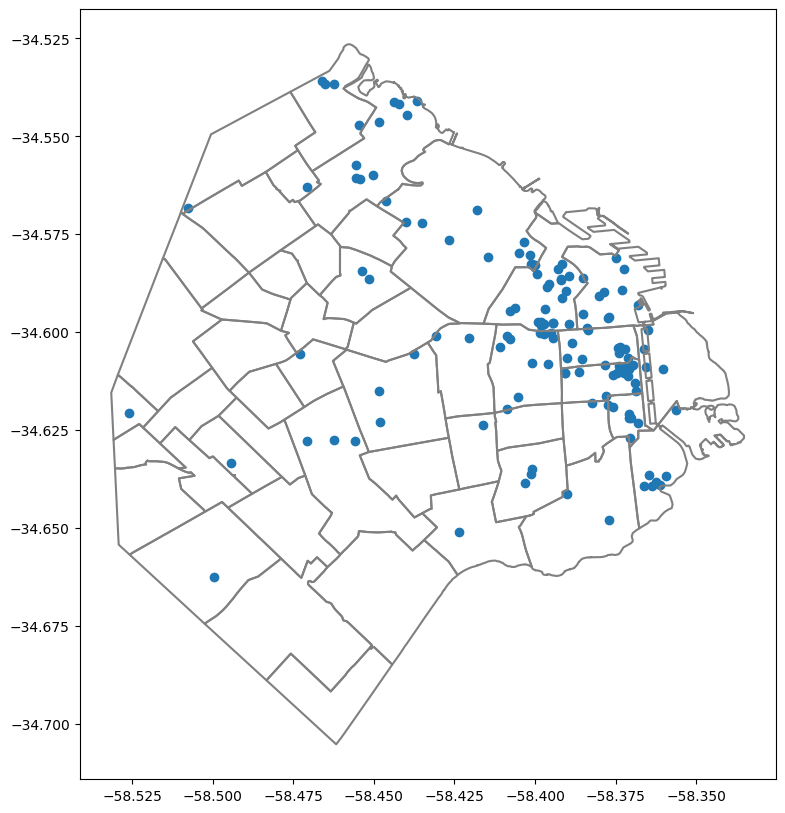

In [3]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [4]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()


### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [6]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila <= fila[np.argsort(fila)[m]] )
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [7]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

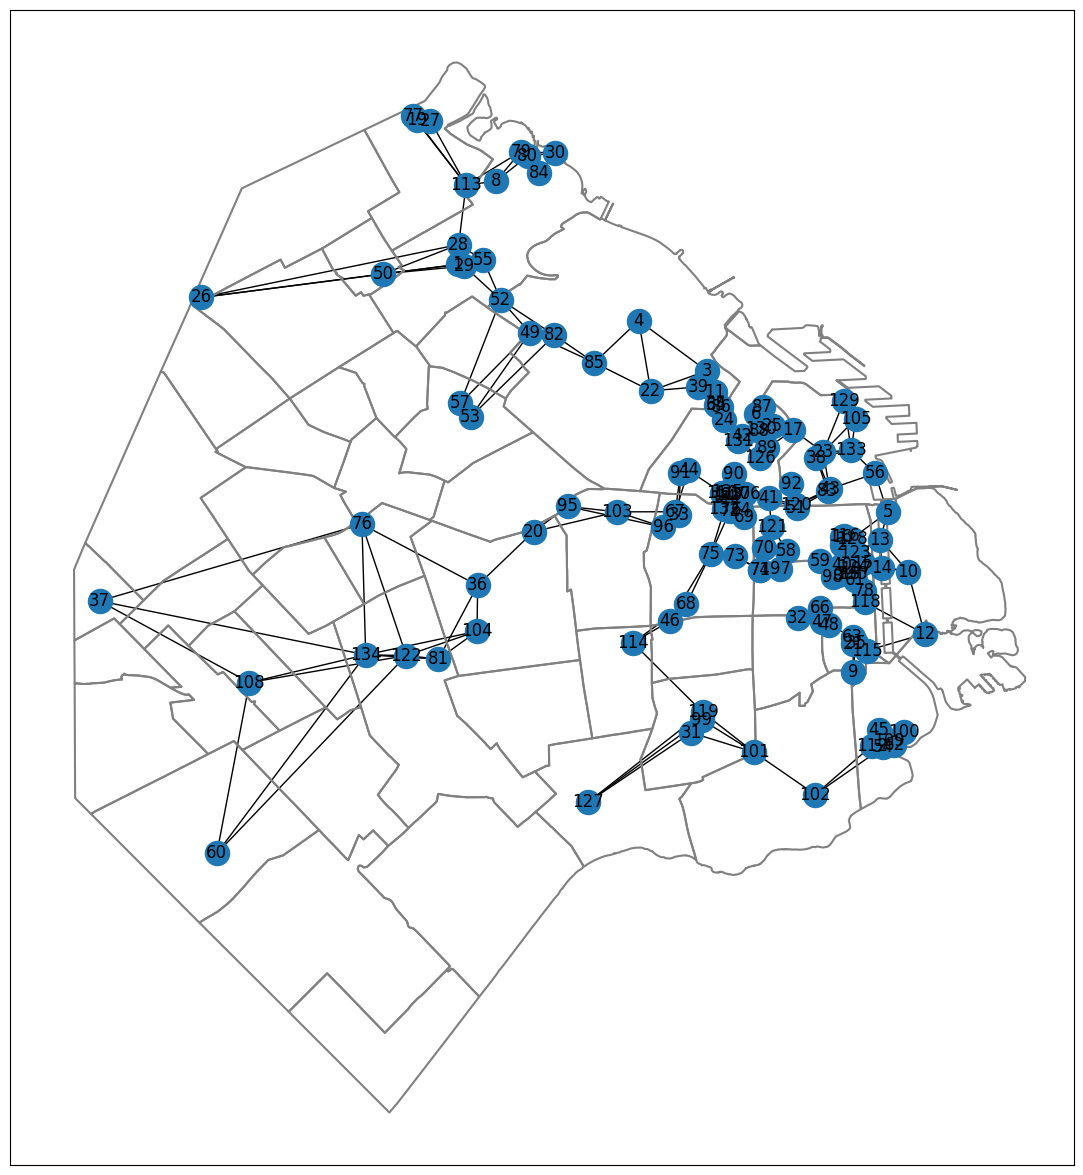

In [8]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1: 
### Partiendo de la ecuacion 3, y sabiendo que:
${\alpha} > 0 \ y\ N > 0 $ , Mp = b, con M = $(N/ \alpha)(I − (1 − \alpha)C)$ y b = 1.

Ecuacion 3: $p = (1 − \alpha) C p + \frac{\alpha}{N} \mathbf{1}$.

Queremos ver que el vector de rankings anterior p es solucion de la ecuacion Mp = b.

Si partimos de la ecuacion de p tenemos: 

\begin{align*}
                       p = (1 − \alpha) C p + \frac{\alpha}{N} \mathbf{1}   \\

        p - (1 − \alpha) C p  = \frac{\alpha}{N} \mathbf{1} \\

         (I - (1 - \alpha)C)p = \frac{\alpha}{N} \mathbf{1} \\

    (\frac{N}{\alpha})(I - (1 - \alpha)C)p = \frac{\alpha}{N} \mathbf{1}(\frac{N}{\alpha})\\

    (\frac{N}{\alpha})(I - (1 - \alpha)C)p = (1) \\
    
                      Mp = b \\
\end{align*}
Luego el vector p es solucion de la ecuacion Mp = b

## Punto 2

2. ¿Que condiciones se deben cumplir para que exista una unica solucion a la ecuacion del punto anterior? ¿Se cumplen estas condiciones para la matriz M tal como fue construida para los museos, cuando 0 < α < 1? Demuestre que se cumplen o de un contraejemplo.

Para que la ecuacion $Mp = b$ tenga una unica solucion, debemos ver que este sistema es compatible determinado. Para ello, la matriz $M = \frac{N}{\alpha}(\mathbf{I} - (1 - \alpha) C)$ debe ser inversible y para que esto ocurra la matriz C debe serlo dado que I es inversible y tanto $(N/\alpha)$ como $(1 - \alpha)$ no influyen en la inversibilidad. 

Sabemos que C es la matriz de transiciones, $C = A^{t}K^{-1}$ donde A es la matriz de adyacencias entre los m museos mas cercanos de uno particular y K es la matriz de probabilidad de ir desde el museo i al j. 

Analizamos K:

 Sabemos que K es una matriz diagonal por como esta definida, pues es la sumatoria desde h = i hasta N de $A_{ih}$ cuando estamos en la posicion i y 0 en caso contrario. Dado que estamos en el caso en el que la matriz A no es pesada, esta sumatoria nos daria m en cada posicion de la diagonal. Luego dado que todos los numeros de la diagonal son positivos el determinante de K no es cero y por lo tanto es inversible.

Analizamos A:

La matriz A esta determinada por el parametro m que es la cantidad de museos mas cercanos que tomamos en cuenta como posibilidades a la hora de ir de un museo a otro. Las columnas de A (las filas de $A^{t}$) representan los museos que tienen cerca a un museo i. Teniendo esto en cuenta notamos que podria pasar que un museo particular no este dentro de los m mas cercanos de ninguno, generando que hubiera una fila (de $A^{t}$) completa de 0. Esto implicaria que la matriz $A^{t}$ no fuera inversible, por ende tampoco su multiplicacion con $K^{-1}$.

Dado esto, podemos concluir que no necesariamente la matriz C es inversible y consecuentemente tampoco M. Para que lo fueran deberia pasar que todo museo este dentro de los mas cercanos de aunque sea uno.

Luego, veamos para que valores de $\alpha$ M es inversible.

Es facil notar que para el caso $\alpha = 0$ la ecuacion $Mp = b$ no tiene solucion, pues tenemos una indeterminacion "$N/0$" dando a que no haya solucion para el sistema.

Para el caso $\alpha = 1$:
\begin{align*}
 M = \frac{N}{\alpha} ( I - (1 - \alpha)C) \\
 M = \frac{N}{1} ( I - (1 - 1)C) \\
 M = N(I - (0)C) \\
 M = N * I \\
\end{align*}

Por lo que $p = \frac{1}{N}\mathbf{1}$ pues por la ecuacion 3:

\begin{align*}
 p = (1 − \alpha) C p + \frac{\alpha}{N} \mathbf{1} \\
 p = 0 C p + \frac{1}{N} \mathbf{1} \\
 p = \frac{1}{N} \mathbf{1} \\
\end{align*}

Finalmente, al tomar estos valores para $Mp = b$ obtenemos:

\begin{align*}
 (N * I) \frac{1}{N} \mathbf{1} = \mathbf{1} \\
 I \mathbf{1} = \mathbf{1}  \\
 \mathbf{1} = \mathbf{1} \\
\end{align*}

Podemos concluir que para $\alpha = 1$, M es inversible y por lo tanto tiene solucion única.


El siguiente intervalo a analizar es ver si podemos demostrar que  M  es invertible para $0 < \alpha < 1$. Para ello usaremos el teorema de la dimensión:


\begin{align*}
    \dim(\text{Nu}(M)) + \dim(\text{Im}(M)) = N
\end{align*}


Para que el sistema Mp = b tenga una única solución, debe cumplirse que $\text{Nu}(M) = \{0\}$, es decir, que la única solución de  Mx = 0 sea  x = 0. Esto ocurre si y solo si las columnas de M son linealmente independientes.

Recordemos que:

\begin{align*}
 M = \frac{N}{\alpha} \left( I - (1 - \alpha) C \right)
\end{align*}

Como \( $\frac{N}{\alpha}$ \) es un escalar positivo, no afecta la nulidad del núcleo, así que basta estudiar la matriz:

\begin{align*}
B = I - (1 - \alpha) C
\end{align*}

Sabemos que:

- Cada columna de C suma 1,
- $0 < \alpha < 1 \Rightarrow (1 - \alpha) < 1$,
- Entonces cada columna de B suma $\alpha > 0$, y ninguna columna es nula.

Además, como cada columna de C representa combinaciones distintas de conexiones en la red (ya que cada museo se conecta con sus  m vecinos más cercanos), se puede afirmar que las columnas de B son linealmente independientes. Por lo tanto:

\begin{align*}
\dim(\text{Núcleo}(B)) = 0 \quad \Rightarrow \quad \dim(\text{Núcleo}(M)) = 0
\end{align*}

Entonces M es invertible, y el sistema Mp = b tiene una única solución para todo $\alpha \in (0,1)$.

[[0 0 1 1]
 [0 0 1 1]
 [1 0 0 1]
 [1 0 1 0]]


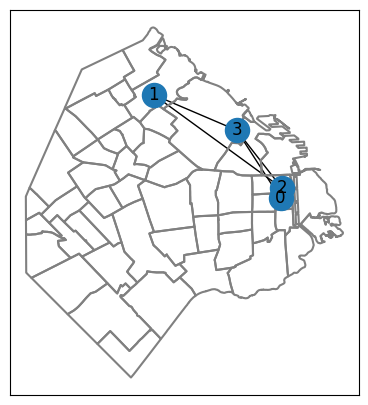

In [57]:

barrios.boundary.plot(color='gray',ax=ax)

D2 = museos[:4].to_crs("EPSG:22184").geometry.apply(lambda g: museos[:4].to_crs("EPSG:22184").distance(g)).round().to_numpy()
B = construye_adyacencia(D2,2)
G2 = nx.from_numpy_array(B) 
G2_layout = {i:v for i,v in enumerate(zip(museos[:4].to_crs("EPSG:22184").get_coordinates()['x'],museos[:4].to_crs("EPSG:22184").get_coordinates()['y']))}
fig, ax = plt.subplots(figsize=(5, 5)) 
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) 
nx.draw_networkx(G2,G2_layout,ax=ax)

print(B)

Como podemos ver en la matriz y en la figura anterior, el museo 1 esta demasiado alejado del resto como para estar dentro de los mas cercanos de otro, generando una columna de ceros en la matriz de adyacencias resultando posteriormente en una C no inversible.

## Punto 3:

In [58]:
def calculaLU(matriz):
    U = np.copy(matriz)
    L = np.zeros_like(matriz)

    for fila in range(len(matriz)):
        for col in range(fila+1, len(matriz)):
            coeficiente = U[col][fila] / U[fila][fila]
            L[col][fila] = coeficiente
            for k in range(fila, len(matriz)):
                U[col][k] -= coeficiente * U[fila][k]

    for i in range(len(matriz)):
        L[i][i] = 1
    return L, U

In [59]:
def calcula_matriz_C(A): 
    n = A.shape[0]
    K = np.zeros((n,n))
    
    suma_col = np.sum(A, axis = 1)
    K = np.diag(suma_col)
    
    Kinv = np.zeros((n, n))
    for i in range(n):
        if K[i, i] != 0:
            Kinv[i, i] = 1.0 / K[i, i] # Calcula inversa de la matriz K, que tiene en su diagonal la suma por filas de A traspuesta
    C = A.T @ Kinv  # Calcula C multiplicando Kinv y A

    return C

In [72]:
def punto_tres(m, alpha):
    A = construye_adyacencia(D,m)
    C = calcula_matriz_C(A)
    N = C.shape[0]
    b = np.ones(N)
    M = (N / alpha) * (np.identity(N) - (1-alpha) * C)

    L, U = calculaLU(M)

    # Resolvemos Ly = b
    y = scipy.linalg.solve_triangular(L, b, lower=True)
    # Resolvemos Up = y
    p = scipy.linalg.solve_triangular(U, y, lower=False)

    p_norm = p / p.sum()  # Normalizamos

    return p_norm


In [ ]:
def punto_tres_testing_img(m, alpha):
    A = construye_adyacencia(D,m)
    C = calcula_matriz_C(A)
    N = A.shape[0]
    b = np.ones(N)*(alpha /N)
    I = np.eye(N)
    M = (N / alpha) * ( I - (1-alpha) * C)

    L, U = calculaLU(M)
    
    # Resolvemos Ly = b
    y = scipy.linalg.solve_triangular(L, b, lower=True)
    # Resolvemos Up = y
    p = scipy.linalg.solve_triangular(U, y, lower=False)
    
    p_norm = p / p.sum()  # Normalizamos

    return p_norm, A

1 puesto:  Museo de Odontología
2 puesto:  Museo de la Facultad de Odontología
3 puesto:  Museo de Farmacobotánica


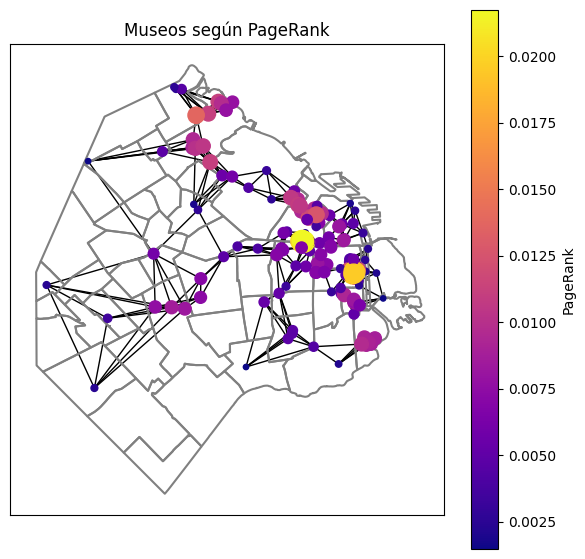

In [ ]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles

p, B = punto_tres_testing_img(m=5, alpha=1/5)
invertido = np.argsort(p)[::-1]
print("1 puesto: ",museos.iloc[invertido[0]]['name'])
print("2 puesto: ",museos.iloc[invertido[1]]['name'])
print("3 puesto: ",museos.iloc[invertido[2]]['name'])

# Crear red
G2 = nx.from_numpy_array(B)
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

fig, ax = plt.subplots(figsize=(7, 7)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G, G_layout, node_size=p*factor_escala, with_labels=False, ax=ax, node_color=p, cmap=plt.cm.plasma)

escala = plt.cm.ScalarMappable(cmap=plt.cm.plasma)
escala.set_array(p)
plt.colorbar(escala, ax=ax, label='PageRank')

plt.title("Museos según PageRank")
plt.show() 


Si bien la red está bastante repartida por todo el territorio, se destacan algunos puntos clave con nodos grandes y claros que actúan como centros de influencia en distintas zonas.

+ En la zona noreste (correspondiente a los barrios más céntricos de CABA como Recoleta, San Nicolás o Retiro), hay una fuerte concentración de nodos grandes y de colores claros/amarillos.
Esto indica que los museos más importantes o influyentes de la red se encuentran ahí por lo que tienen alto PageRank, es decir, muchas conexiones o vínculos con otros museos que también son relevantes.

+ En los extremos del mapa (sobre todo hacia el sur y el oeste) los nodos son más chicos y oscuros. Esto indica que esos museos tienen un PageRank bajo, lo que podría implicar menor cantidad de visitas o menos conexiones con el resto de la red.

In [73]:
valores = []
for m in [1, 3, 5, 10]:
    print("--------", m, "--------")
    p = punto_tres(m=m, alpha=1/5)
    masImportantes = np.argsort(p)[::-1][:3]

    for pos, idx in enumerate(masImportantes):
        valores.append({
            "m": m,
            "rank": pos,
            "museo": museos.iloc[idx]['name'],
            "puntaje": p[idx]
        })

df = pd.DataFrame(valores)

-------- 1 --------
-------- 3 --------
-------- 5 --------
-------- 10 --------


Generando imagen para m = 1


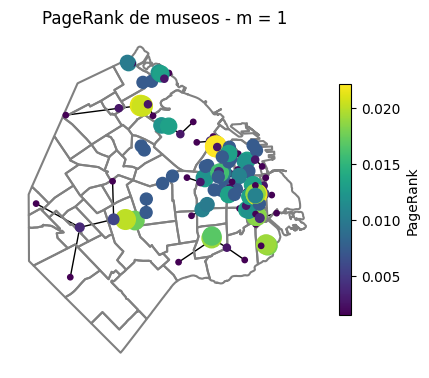

Generando imagen para m = 3


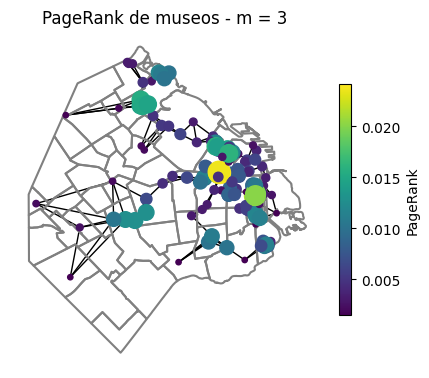

Generando imagen para m = 5


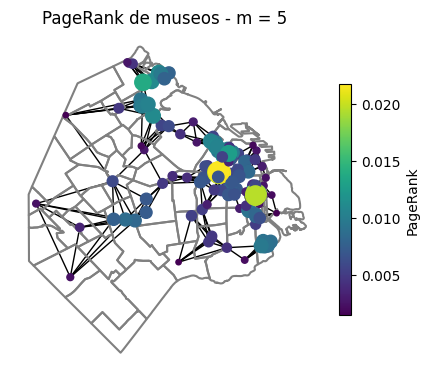

Generando imagen para m = 10


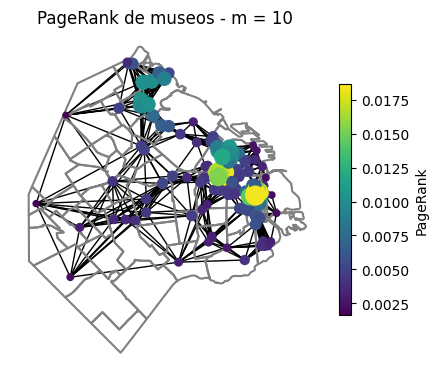

In [ ]:
factor_escala = 1e4
colormap = plt.cm.viridis

# Loop para m = 1, 3, 5, 10
for m in [1, 3, 5, 10]:
    print(f"Generando imagen para m = {m}")
    pr, A = punto_tres_testing_img(m=m, alpha=1/5)
    
    # Crear red
    G = nx.from_numpy_array(A)
    G_layout = {i: v for i, v in enumerate(zip(
                museos.to_crs("EPSG:22184").get_coordinates()['x'],
                museos.to_crs("EPSG:22184").get_coordinates()['y']))}

    # Graficar
    fig, ax = plt.subplots(figsize=(5, 5))
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray', ax=ax)
    nx.draw_networkx(G, G_layout, node_size=pr * factor_escala, node_color = pr, ax=ax, cmap=colormap, with_labels=False)
    ax.set_title(f"PageRank de museos - m = {m}")
    ax.axis("off")

    #Graficar barra lateral
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=min(pr), vmax=max(pr)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label("PageRank")

    plt.show()

    # Guardamos la imagen
    #plt.savefig(f"mapa_museos_pagerank_m{m}.png", dpi=300, bbox_inches="tight")
    #plt.close()
    #print(f"Imagen guardada como mapa_museos_pagerank_m{m}.png")

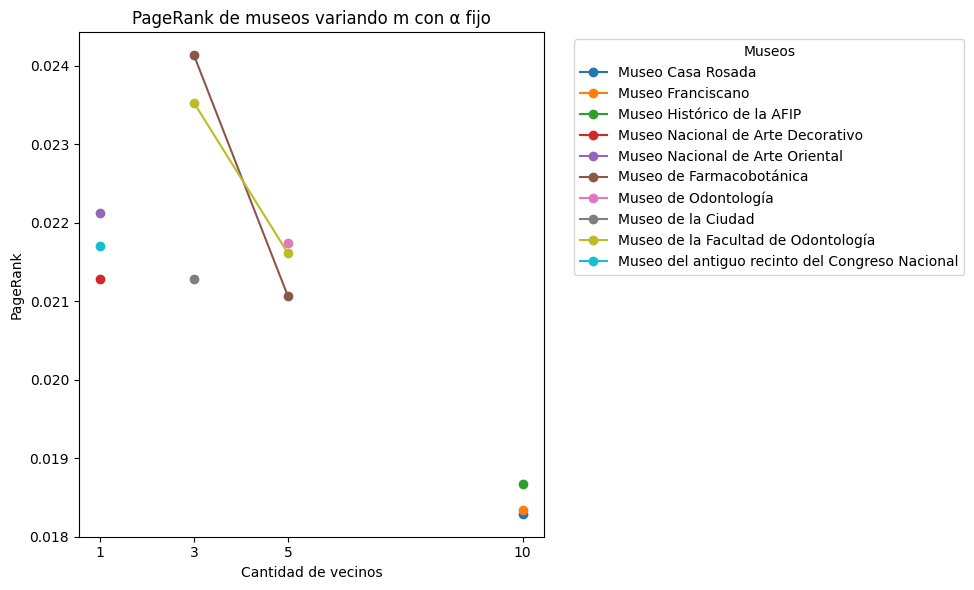

In [ ]:
# Grafico para analizar el pagerank segun la cantidad de vecinos con alpha fijo
plt.figure(figsize=(10, 6))
for museo, puntaje in df.groupby("museo"):
    plt.plot(puntaje["m"], puntaje["puntaje"], 
             label=museo, marker="o")
plt.xticks([1,3,5,10])
plt.xlabel("Cantidad de vecinos")
plt.ylabel("PageRank")
plt.title("PageRank de museos variando m con α fijo")
plt.legend(title="Museos", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


El PageRank de los museos más importantes tiende a ser relativamente estable ante cambios en m, lo cual sugiere una estructura de red robusta. Sin embargo, algunos museos se ven favorecidos al aumentar las conexiones, ganando en importancia a medida que la red se vuelve más interconectada.

In [ ]:
# Datos necesarios para poder realizar el grafico del pagerank variando alpha
valores2 = []
for alpha in [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]:
    print("--------", alpha, "--------")
    p = punto_tres(m=5, alpha=alpha)
    masImportantes = np.argsort(p)[::-1][:3]

    for pos, idx in enumerate(masImportantes):
        valores2.append({
            "alpha": alpha,
            "rank": pos,
            "museo": museos.iloc[idx]['name'],
            "puntaje": p[idx]
        })

df2 = pd.DataFrame(valores2)

-------- 0.8571428571428571 --------
-------- 0.8 --------
-------- 0.6666666666666666 --------
-------- 0.5 --------
-------- 0.3333333333333333 --------
-------- 0.2 --------
-------- 0.14285714285714285 --------


Generando imagen para α = 0.857


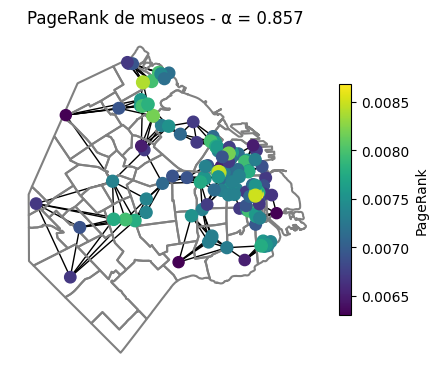

Generando imagen para α = 0.8


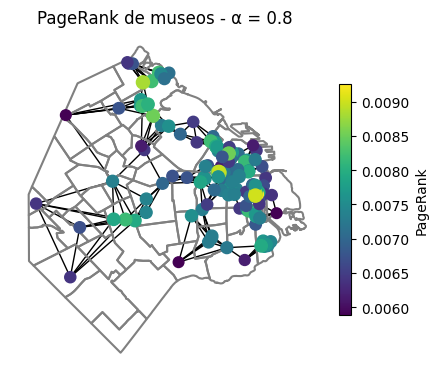

Generando imagen para α = 0.667


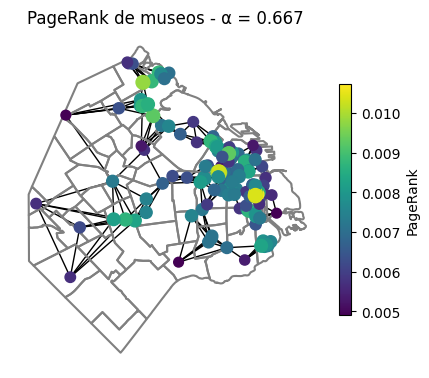

Generando imagen para α = 0.5


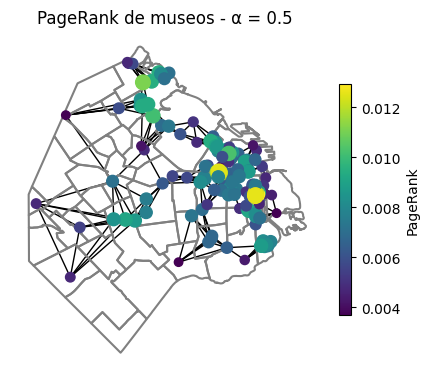

Generando imagen para α = 0.333


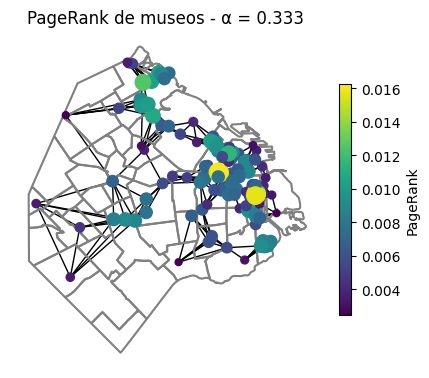

Generando imagen para α = 0.2


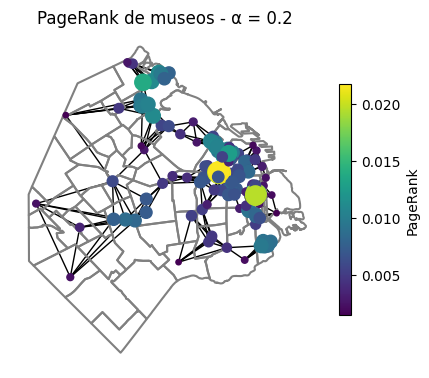

Generando imagen para α = 0.143


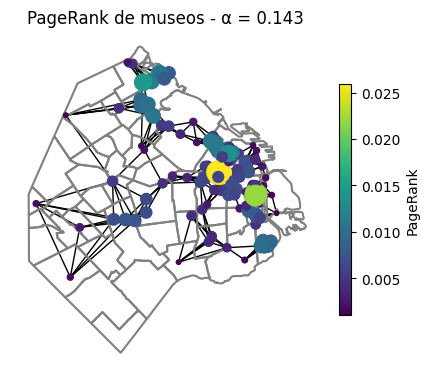

In [ ]:
factor_escala = 1e4
colormap = plt.cm.viridis

for alpha in [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]:
    print(f"Generando imagen para α = {round(alpha, 3)}")

    pr, A = punto_tres_testing_img(m=5, alpha=alpha)

    # Crear red
    G = nx.from_numpy_array(A)
    G_layout = {i: v for i, v in enumerate(zip(
            museos.to_crs("EPSG:22184").get_coordinates()['x'],
            museos.to_crs("EPSG:22184").get_coordinates()['y']))}

    # Preparar gráfico
    fig, ax = plt.subplots(figsize=(5,5))
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray', ax=ax)

    # Dibujar red con color según PageRank
    nx.draw_networkx(
        G, G_layout, node_size=pr * factor_escala, node_color=pr, cmap=colormap, ax=ax, with_labels=False)
    
    # Título y colorbar
    ax.set_title(f"PageRank de museos - α = {round(alpha, 3)}")
    ax.axis("off")

    sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=min(pr), vmax=max(pr)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label("PageRank")

    plt.show()

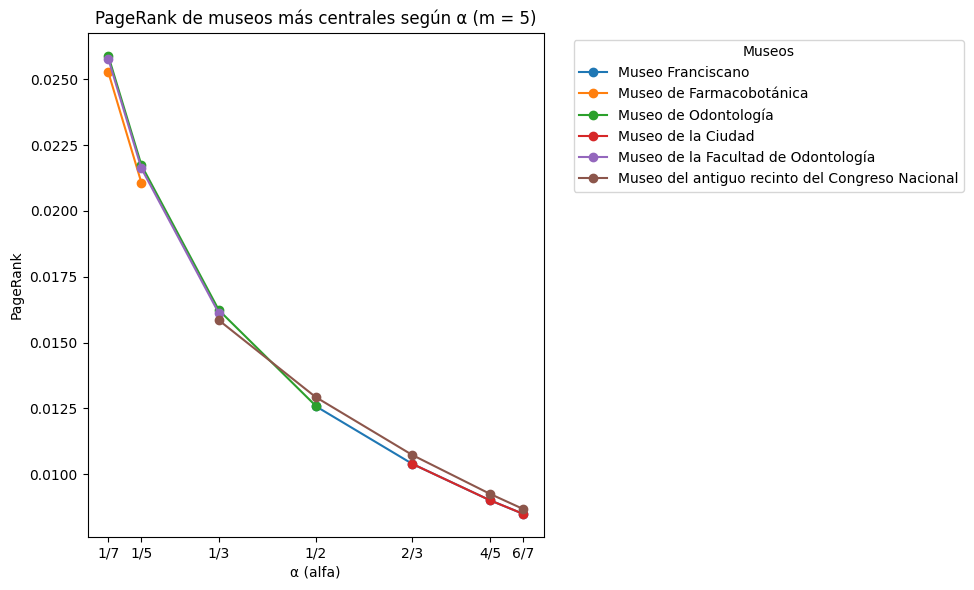

In [77]:
plt.figure(figsize=(10, 6))
for museo, puntaje in df2.groupby("museo"):
    plt.plot(puntaje["alpha"], puntaje["puntaje"], 
             label=museo, marker="o")
plt.xticks([6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7],
           ["6/7", "4/5", "2/3", "1/2", "1/3", "1/5", "1/7"])

plt.xlabel("α (alfa)")
plt.ylabel("PageRank")
plt.title("PageRank de museos más centrales según α (m = 5)")
plt.legend(title="Museos", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

En este gráfico se estudia cómo cambia el PageRank de los museos más centrales cuando se varía el parámetro $\alpha$, manteniendo fijo m=5 (cada museo conectado a sus 5 vecinos más cercanos).
Se observa que todos los museos pierden valor de PageRank de forma bastante suave pero sistemática a medida que $\alpha$ crece.
Aunque todos los puntajes bajan, algunos museos (como el Museo de la Facultad de Odontología y el Museo del antiguo recinto del Congreso Nacional) logran mantenerse en la parte alta de los rankings para todos los valores de $\alpha$. Esto indica que su importancia no depende exclusivamente de los enlaces, sino también de su ubicación en la red.

## Punto 4:

## Punto 5:

## Punto 6:

In [ ]:
# Calcula la norma 1 de una matriz: el máximo de la suma de los valores absolutos por columna.
def norm_1(A):    
    # Transponemos la matriz y sumamos los valores absolutos por columna
    return max(sum(abs(A[i][j]) for i in range(len(A))) for j in range(len(A[0])))

In [ ]:
def cond_1(M):
    # Calculamos la norma 1 de matriz pasada por parametro
    norm_M = norm_1(M)
     
    N = M.shape[0]
    L, U = calculaLU(M)
    M_inv = np.zeros_like(M)

    # Resolvemos Mx = e_i para cada columna de la inversa
    for i in range(N):
        e_i = np.zeros(N)
        e_i[i] = 1

        # Resolvemos Ly = e_i
        y = scipy.linalg.solve_triangular(L, e_i, lower=True)
        # Resolvemos Ux = y
        x = scipy.linalg.solve_triangular(U, y, lower=False)

        # Ubicamos la columna en la matriz inversa
        M_inv[:, i] = x

    # Calculamos la norma de la inversa de la matriz
    norm_M_inv = norm_1(M_inv)

    # El nro de condición se calcula por norma 1 de M y de inversa de M
    nro_cond = norm_M * norm_M_inv

    return nro_cond

In [ ]:
nro_condicion = cond_1(B)
print(f"El numero de condicion da como resultado= {nro_condicion}")

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, '15'),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 1

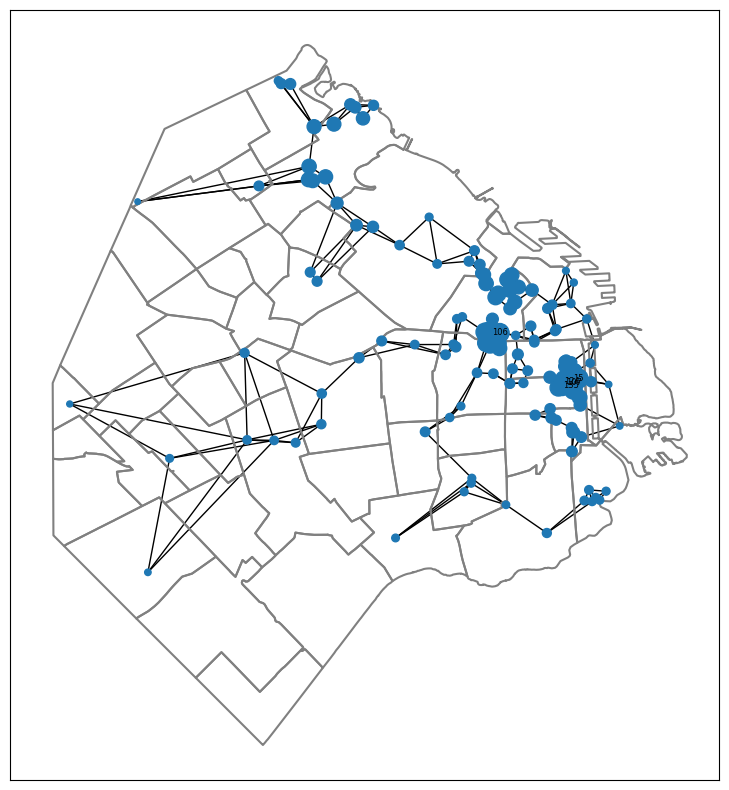

In [16]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = punto_tres(m=m, alpha=1/5)# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres